Combined Data Columns: Index(['Worker_ID', 'Date', 'Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3',
       'High_Low_D4', 'Production_Volume', 'Shift', 'defect_count', 'count',
       'Age', 'Gender', 'Skill_Level'],
      dtype='object')

Feature Columns (X): Index(['Production_Volume', 'Age', 'Gender', 'Skill_Level'], dtype='object')
Target Columns (y): Index(['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4'], dtype='object')

RandomForest: Mean CV MSE = 4.954623847493965
GradientBoosting: Mean CV MSE = 4.952273866231022
LinearRegression: Mean CV MSE = 4.952278097537347
SupportVector: Mean CV MSE = 5.378071429710146

Best model: GradientBoosting with Mean CV MSE = 4.952273866231022

Mean Squared Error for Run_Off_D1: 5.292562991796079
Mean Squared Error for Open_Seam_D2: 3.0785639742247186
Mean Squared Error for SPI_Errors_D3: 4.98624927690371
Mean Squared Error for High_Low_D4: 5.542851679266722
Overall Mean Squared Error: 4.725056980547807
Feature names: 4
X_train shape: 

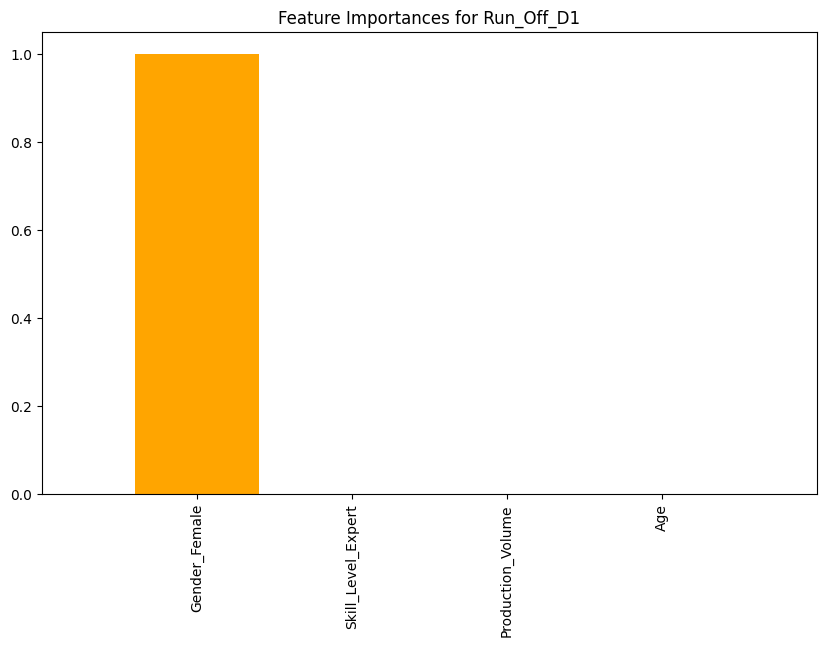

Importances shape: (4,)
indices shape: (4,)


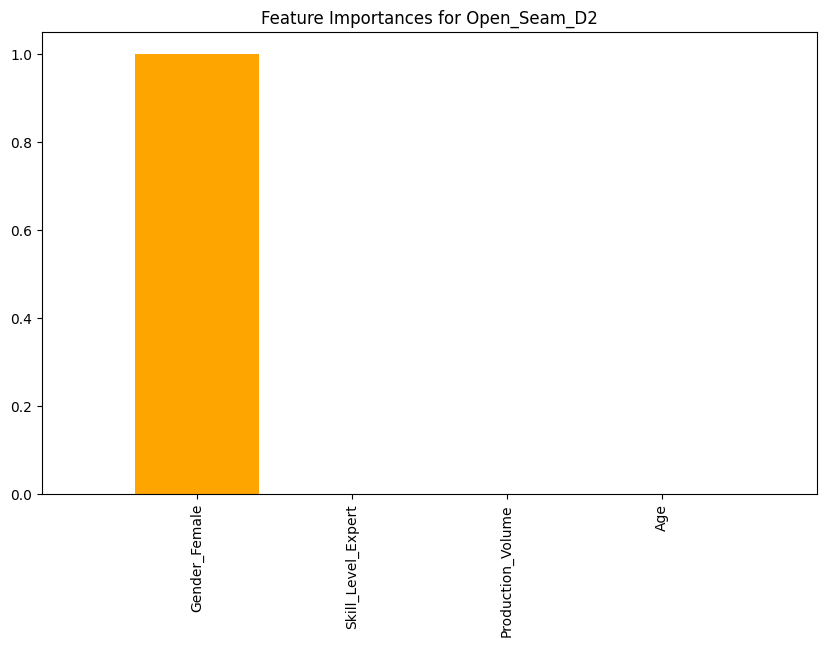

Importances shape: (4,)
indices shape: (4,)


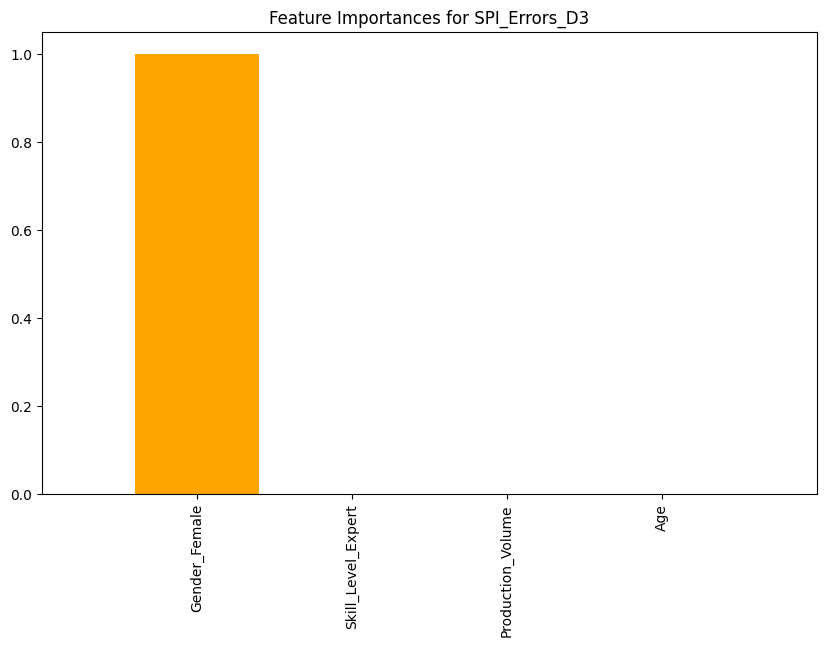

Importances shape: (4,)
indices shape: (4,)


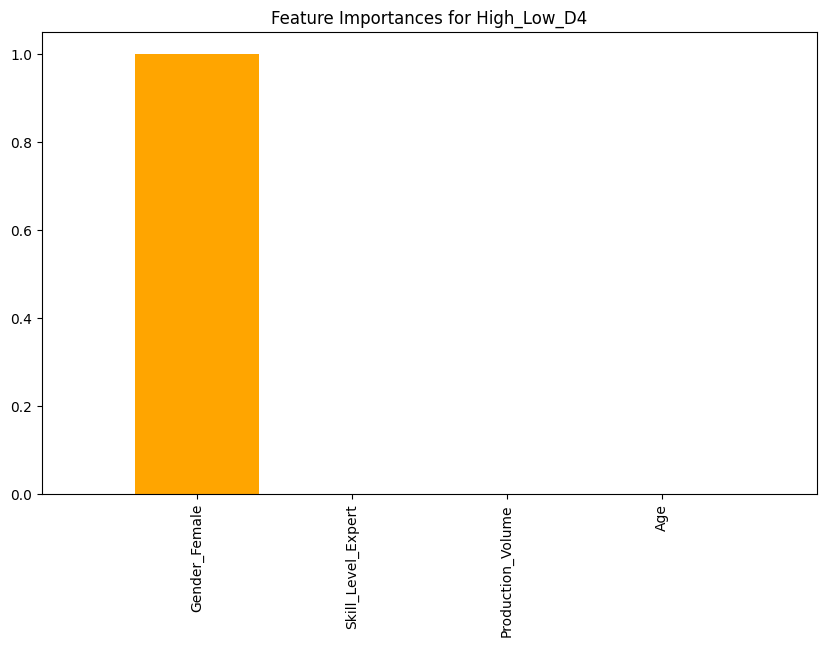

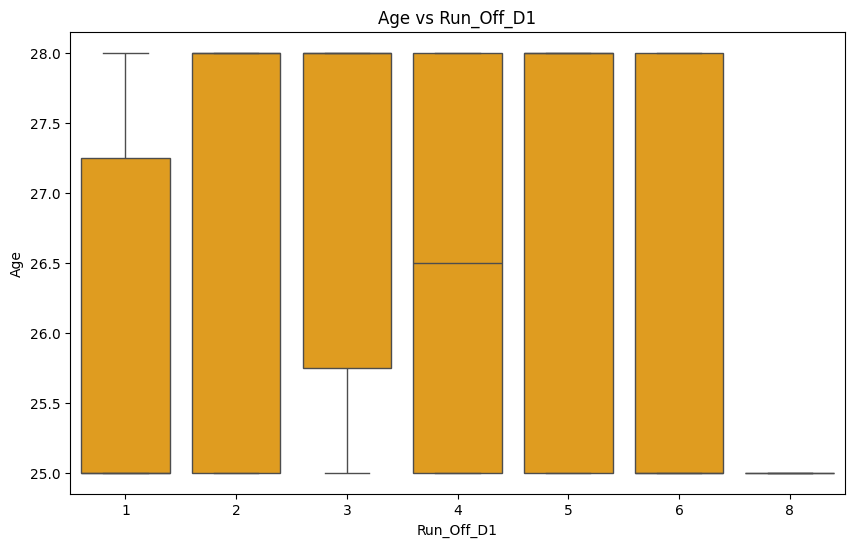

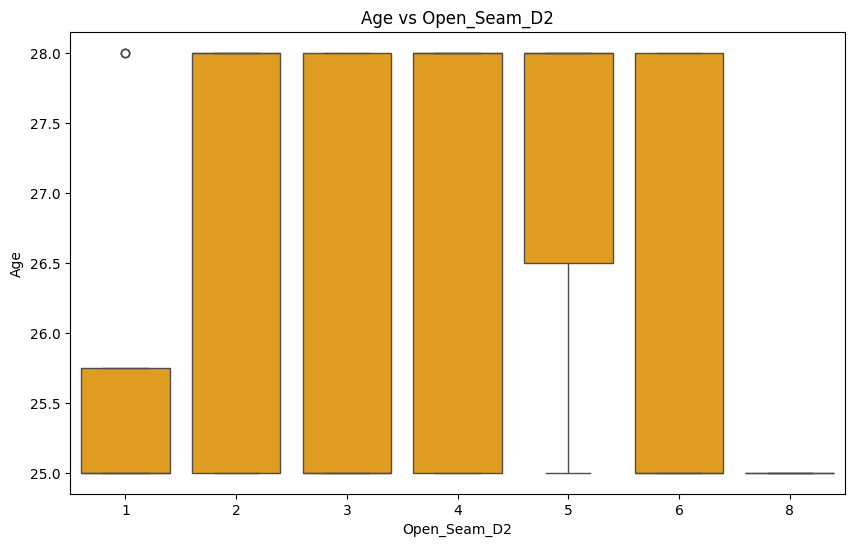

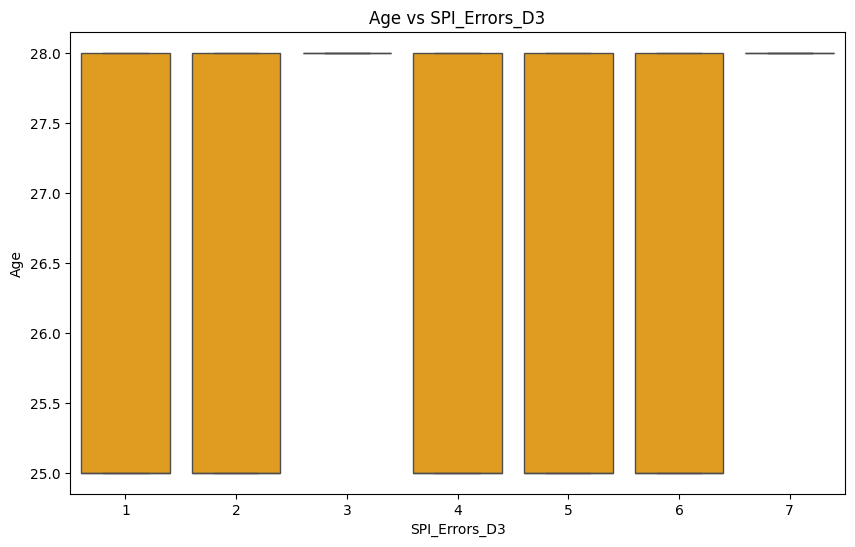

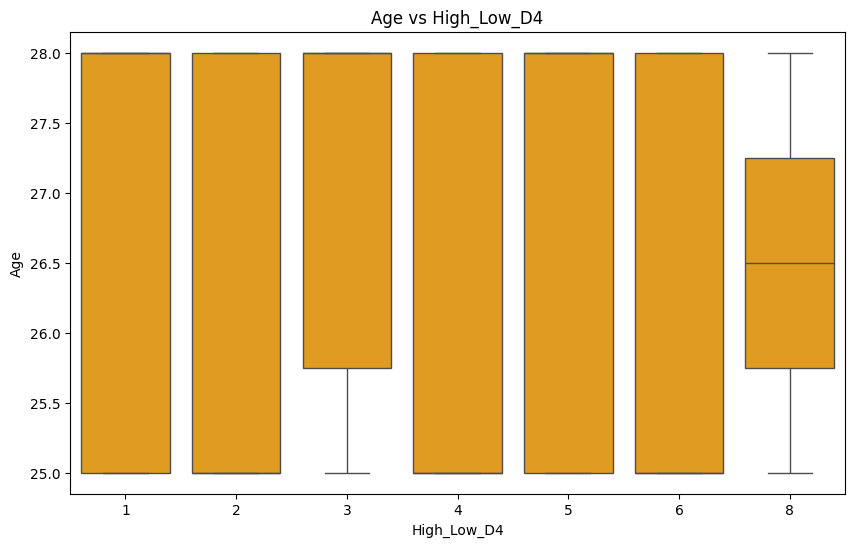

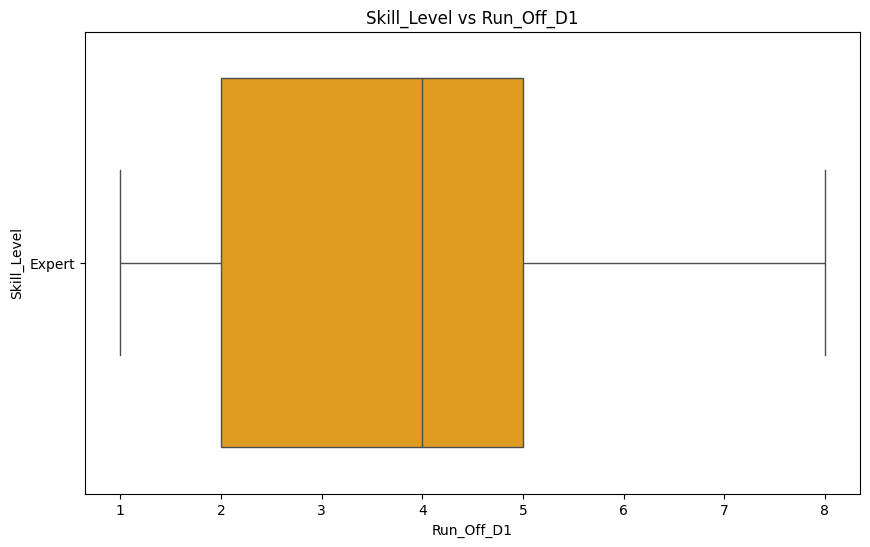

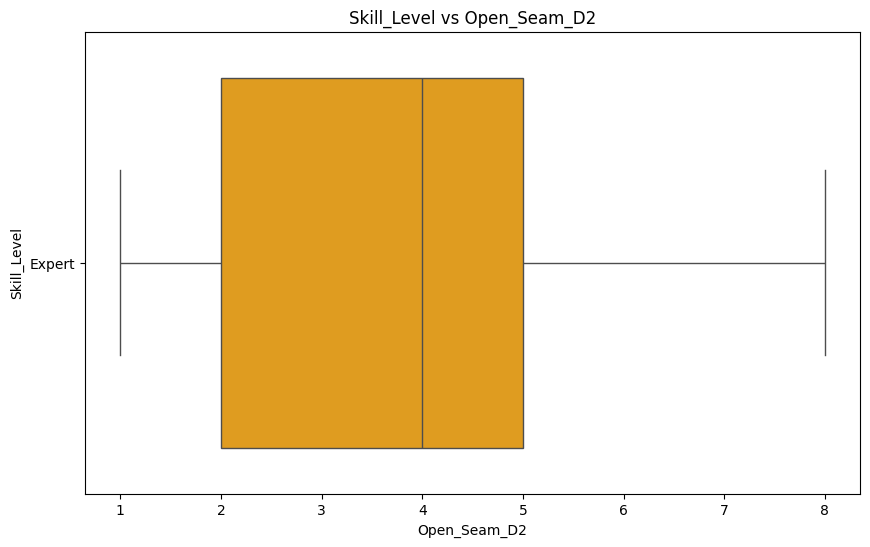

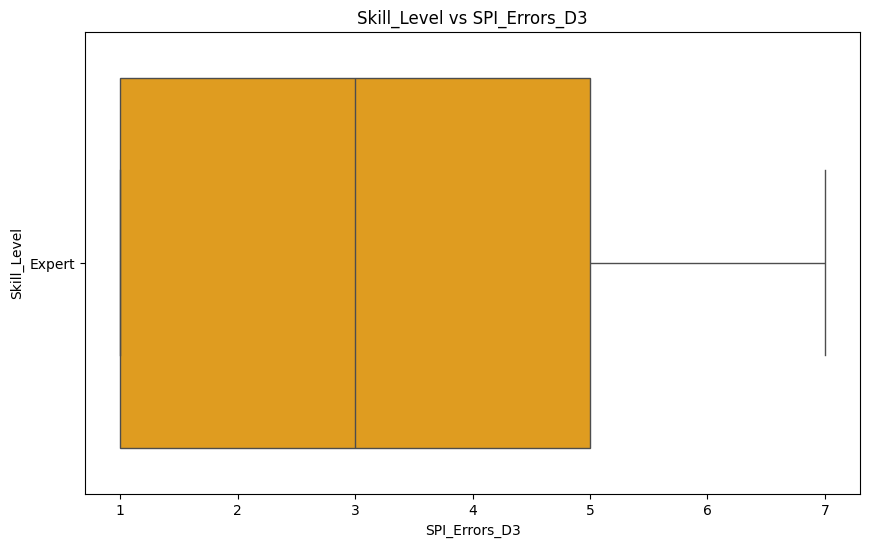

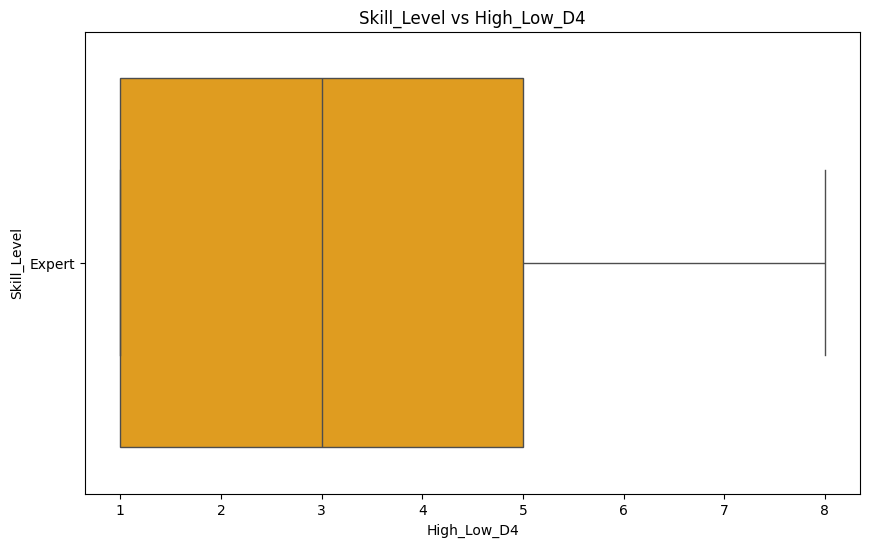

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Read the data
demographic_data = pd.read_csv('demographic_data_dataset.csv')
defect_data = pd.read_csv('updated_worker_defect_details.csv')

# Combine datasets on Worker_ID
combined_data = pd.merge(defect_data, demographic_data, on='Worker_ID')

# Drop unnecessary columns
fields_to_drop = ['Name', 'Joining_Date']
combined_data.drop(columns=fields_to_drop, inplace=True)

# Debugging: Print combined data columns
print("Combined Data Columns:", combined_data.columns)
print()

# Define categorical features for one-hot encoding
categorical_features = ['Gender', 'Skill_Level']
numerical_features = ['Age', 'Production_Volume']

# Ensure that all columns are present
missing_columns = [col for col in categorical_features + numerical_features if col not in combined_data.columns]
if missing_columns:
    raise ValueError(f"The following columns are missing in the combined dataset: {missing_columns}")

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Separate features and target variables
X = combined_data.drop(columns=['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4', 'defect_count', 'count', 'Worker_ID', 'Date', 'Shift'])
y = combined_data[['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']]

# Debugging: Print X and y columns
print("Feature Columns (X):", X.columns)
print("Target Columns (y):", y.columns)
print()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define multiple models
models = {
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'GradientBoosting': MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'SupportVector': MultiOutputRegressor(SVR())
}

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -cv_scores.mean()  # Negate because cross_val_score uses negative MSE
    print(f"{model_name}: Mean CV MSE = {-cv_scores.mean()}")
print()

# Select the best model
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

print(f"Best model: {best_model_name} with Mean CV MSE = {results[best_model_name]}")
print()

# Train the best model on the full training data
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model and print MSE for each defect type
mse_values = mean_squared_error(y_test, y_pred, multioutput='raw_values')
defect_types = ['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']

for defect_type, mse in zip(defect_types, mse_values):
    print(f"Mean Squared Error for {defect_type}: {mse}")

# Overall MSE
overall_mse = mean_squared_error(y_test, y_pred)
print(f"Overall Mean Squared Error: {overall_mse}")

# Function to get feature names after preprocessing
def get_feature_names(preprocessor, numerical_features, categorical_features):
    feature_names = numerical_features
    ohe_categories = preprocessor.transformers_[0][1].categories_
    cat_names = []
    for i, cat in enumerate(categorical_features):
        cat_names.extend([f"{cat}_{ohe_categories[i][j]}" for j in range(len(ohe_categories[i]))])
    feature_names.extend(cat_names)
    return feature_names

# Get the feature names
feature_names = get_feature_names(preprocessor, numerical_features, categorical_features)

# Debugging print statements to verify shapes
print(f"Feature names: {len(feature_names)}")
print(f"X_train shape: {X_train.shape}")
print()

# Plot feature importances for each defect type (for tree-based models)
if hasattr(best_model, 'estimators_'):
    for i, defect_type in enumerate(defect_types):
        importances = pipeline.named_steps['regressor'].estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Debugging print statements to verify shapes
        print(f"Importances shape: {importances.shape}")
        print(f"indices shape: {indices.shape}")

        # Plot the feature importances for each defect type
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importances for {defect_type}")
        plt.bar(range(len(importances)), importances[indices], align='center', color='orange')
        plt.xticks(range(len(importances)), [feature_names[j] for j in indices], rotation=90)
        plt.xlim([-1, len(importances)])
        plt.show()

# Demographic Analysis for Age and Skill Level
def analyze_demographics(data, demographic_feature):
    for defect_type in defect_types:
        subset = data[data[defect_type] > 0]  # Filter rows where the defect type count is greater than 0
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=defect_type, y=demographic_feature, data=subset, color='orange')
        plt.title(f"{demographic_feature} vs {defect_type}")
        plt.show()

# Analyze the effect of Age and Skill Level on each defect type
analyze_demographics(combined_data, 'Age')
analyze_demographics(combined_data, 'Skill_Level')

Combined Data Columns: Index(['Worker_ID', 'Date', 'Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3',
       'High_Low_D4', 'Production_Volume', 'Shift', 'defect_count', 'count',
       'Age', 'Gender', 'Skill_Level', 'Unnamed: 6'],
      dtype='object')

Feature Columns (X): Index(['Production_Volume', 'Age', 'Gender', 'Skill_Level', 'Unnamed: 6'], dtype='object')
Target Columns (y): Index(['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4'], dtype='object')

RandomForest: Mean CV MSE = 4.954623847493965
GradientBoosting: Mean CV MSE = 4.952273866231022
LinearRegression: Mean CV MSE = 4.952278097537348
SupportVector: Mean CV MSE = 5.378071429036066

Best model: GradientBoosting with Mean CV MSE = 4.952273866231022

Mean Squared Error for Run_Off_D1: 5.292562991796079
Mean Squared Error for Open_Seam_D2: 3.0785639742247186
Mean Squared Error for SPI_Errors_D3: 4.98624927690371
Mean Squared Error for High_Low_D4: 5.542851679266722
Overall Mean Squared Error: 4.725056980547807
Feat

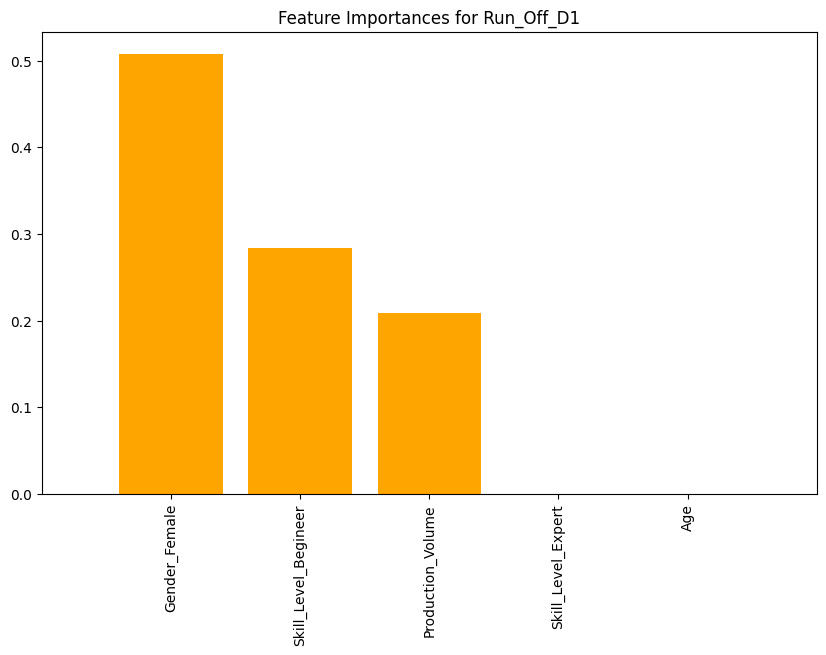

Importances shape: (5,)
indices shape: (5,)


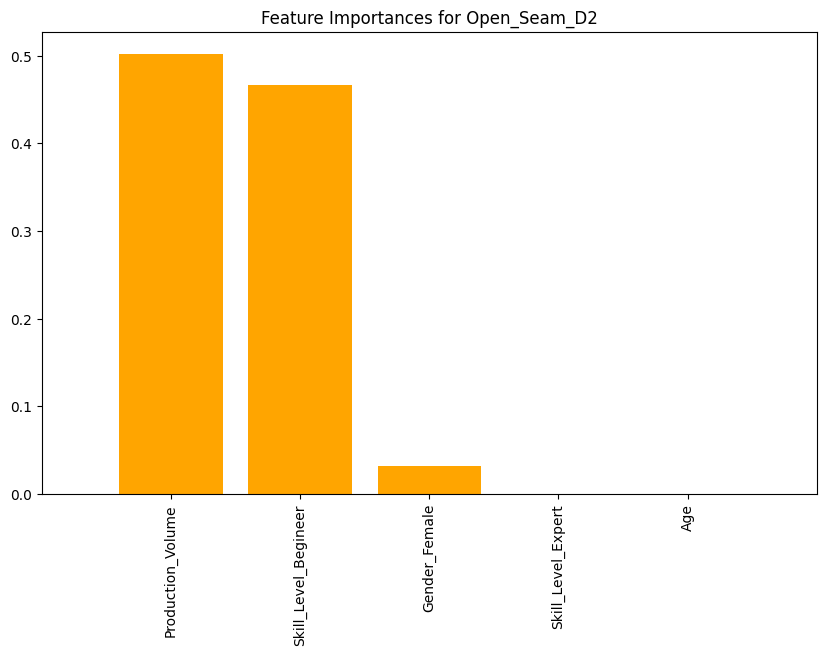

Importances shape: (5,)
indices shape: (5,)


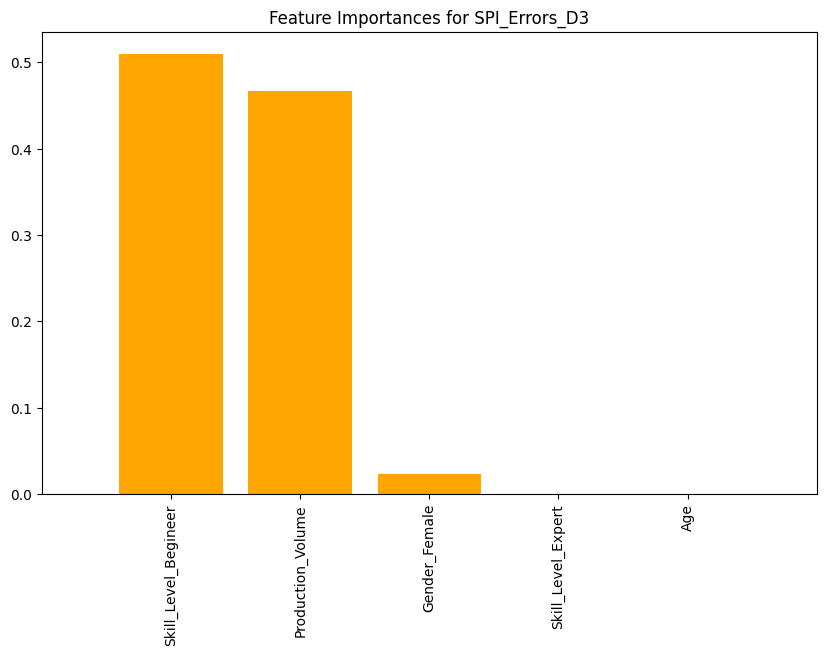

Importances shape: (5,)
indices shape: (5,)


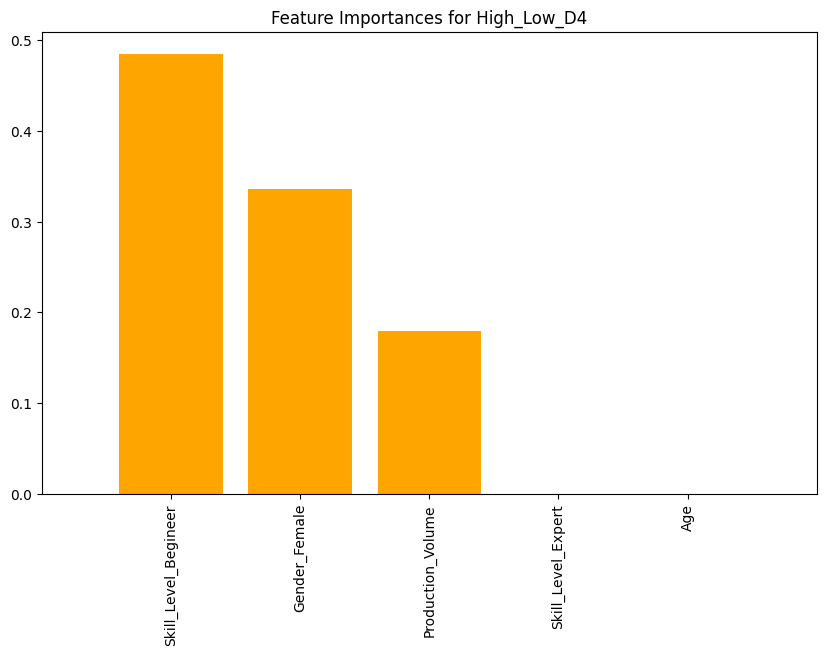

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/3182167064.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


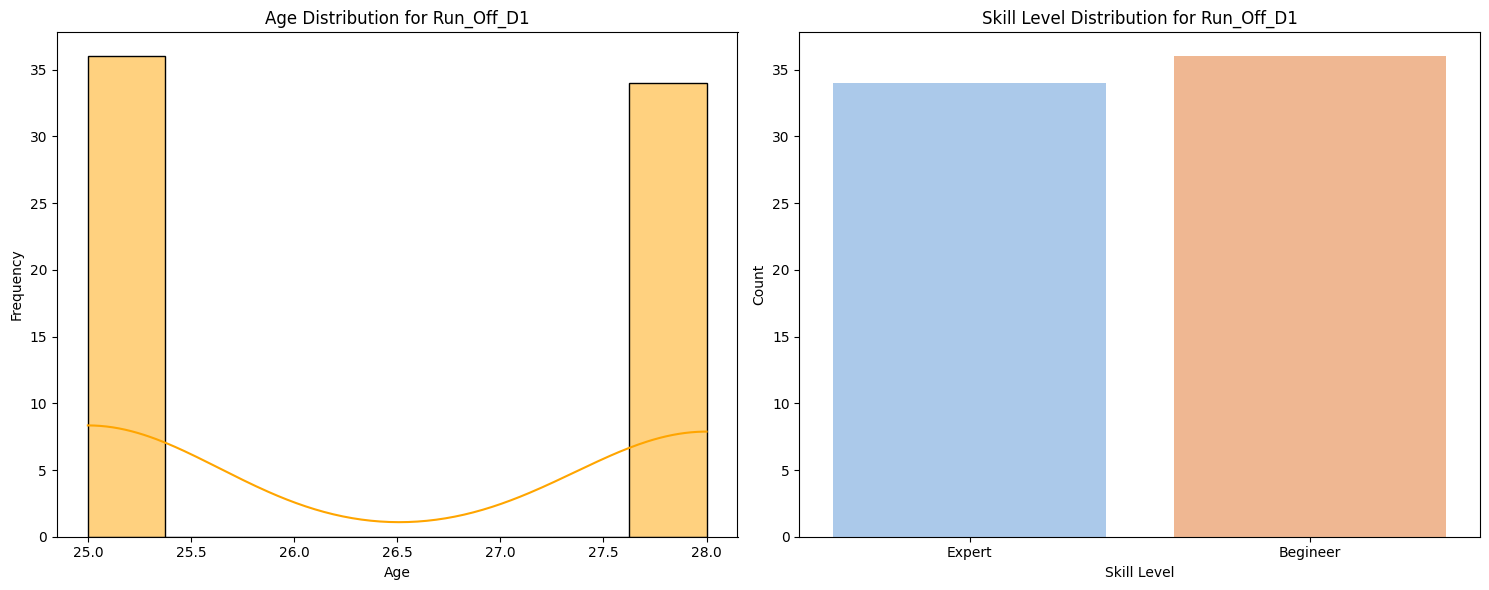

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/3182167064.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


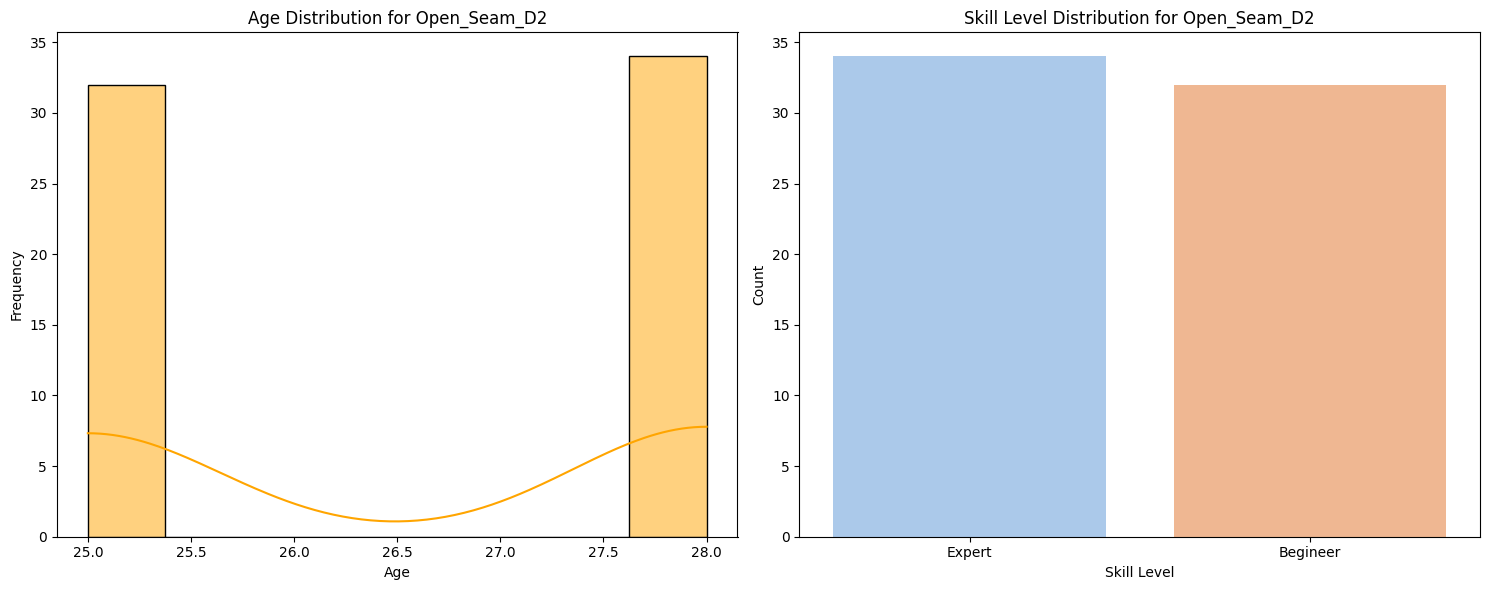

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/3182167064.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


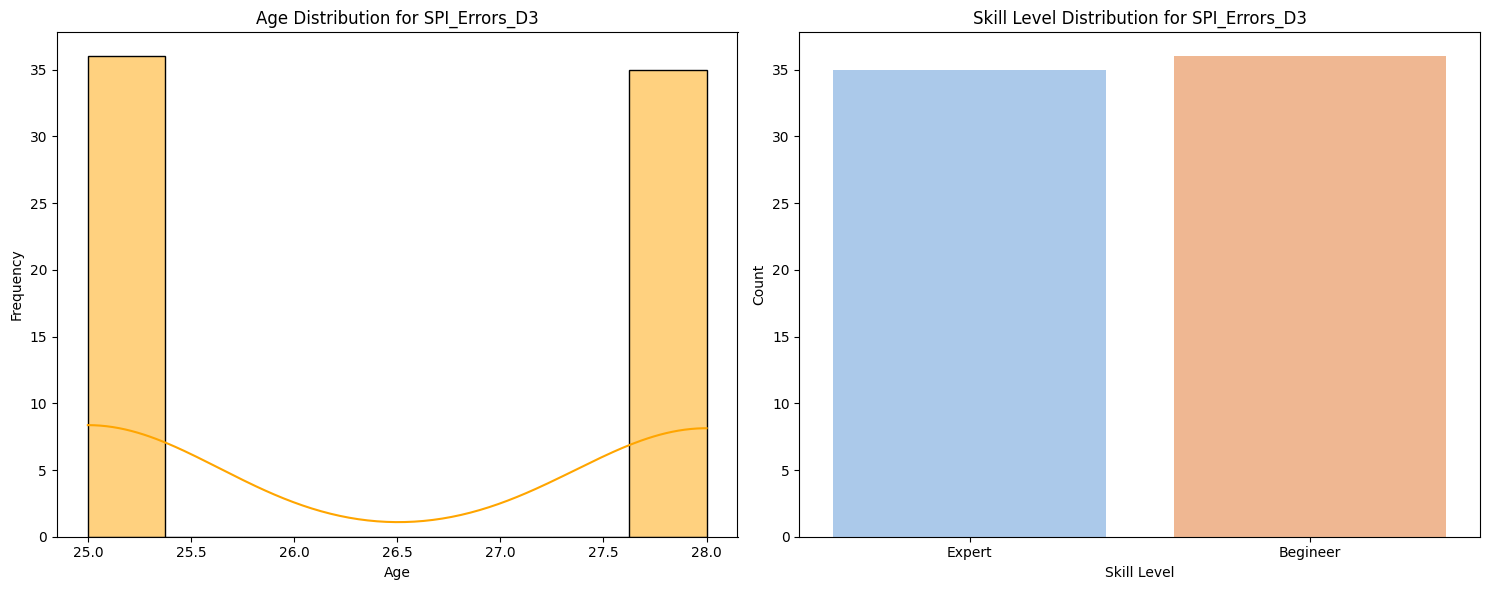

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/3182167064.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


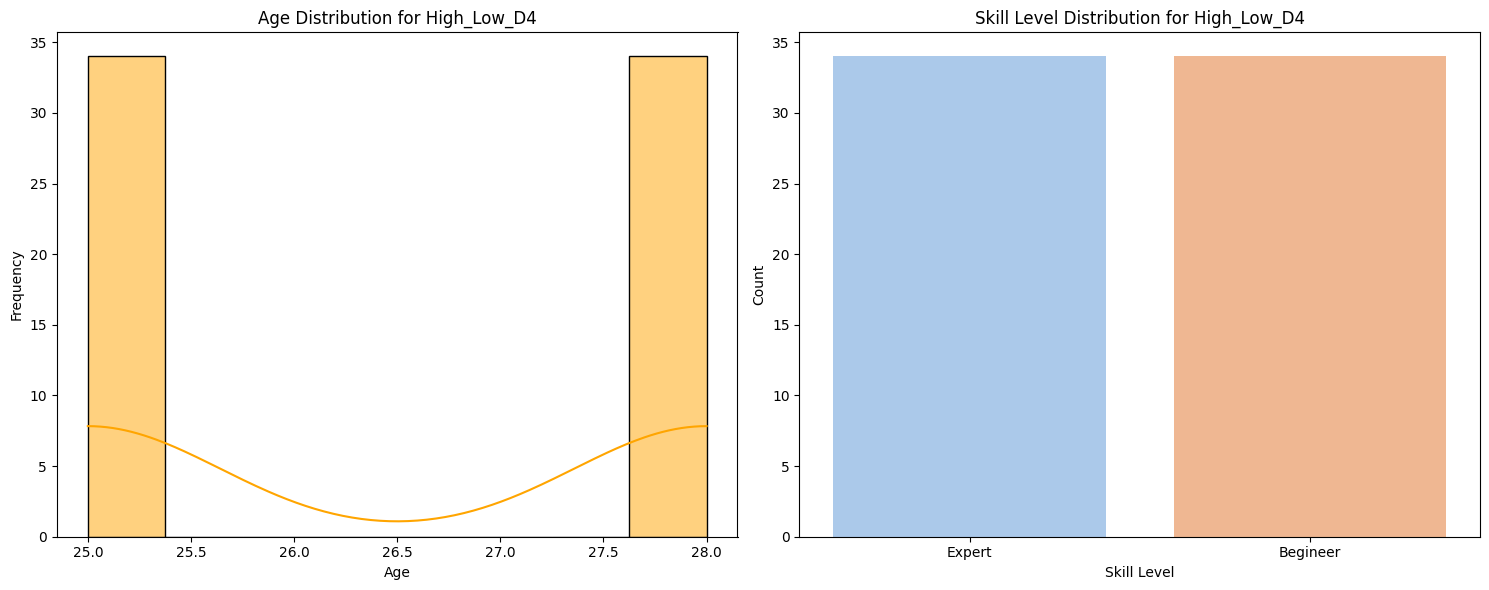

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/3182167064.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


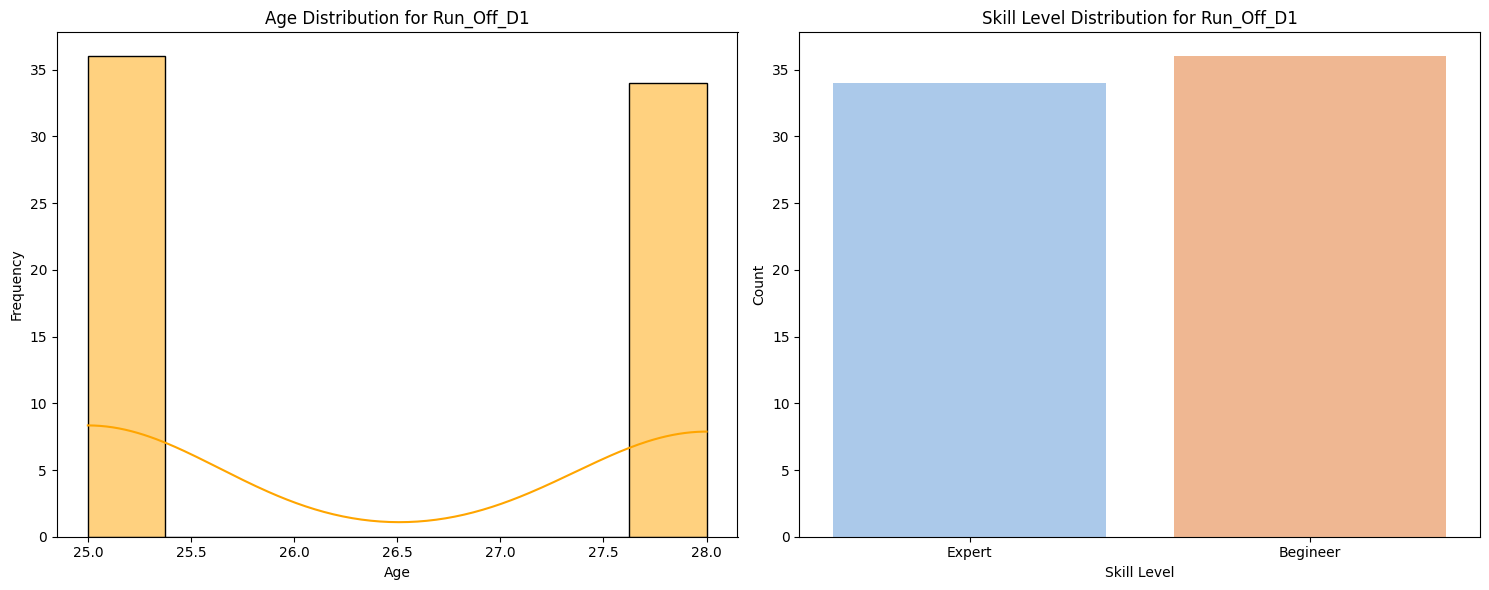

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/3182167064.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


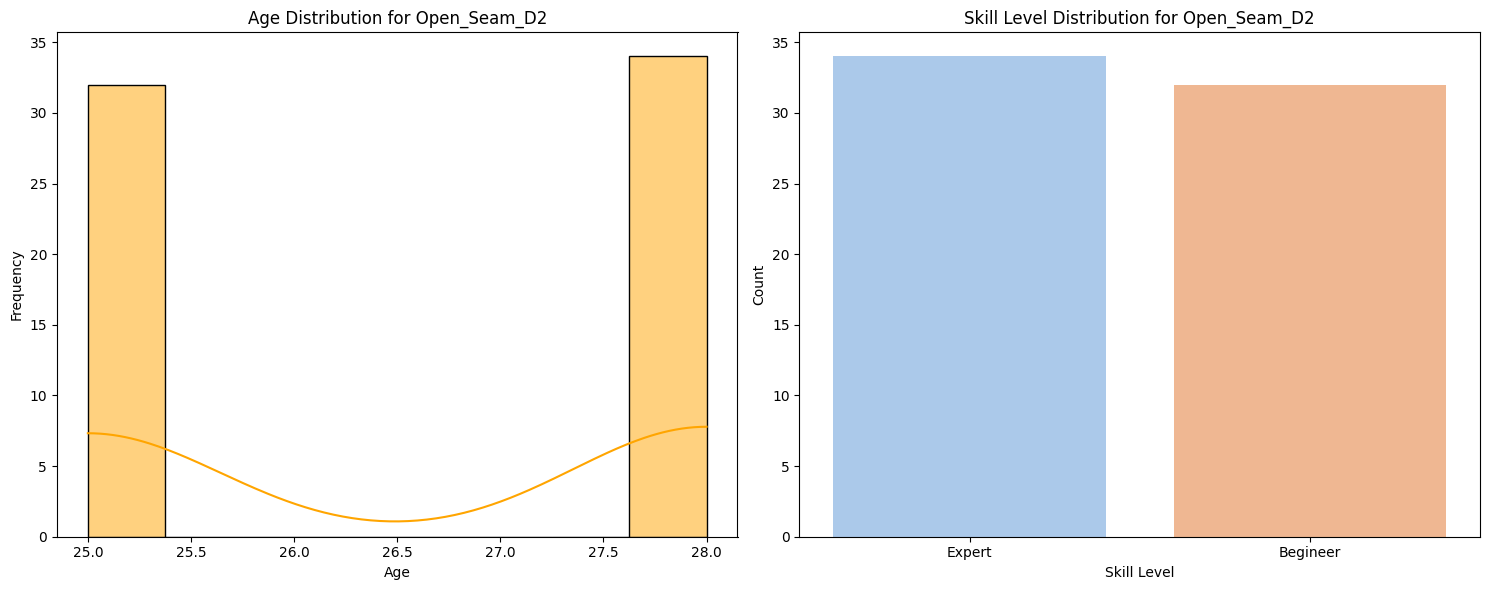

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/3182167064.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


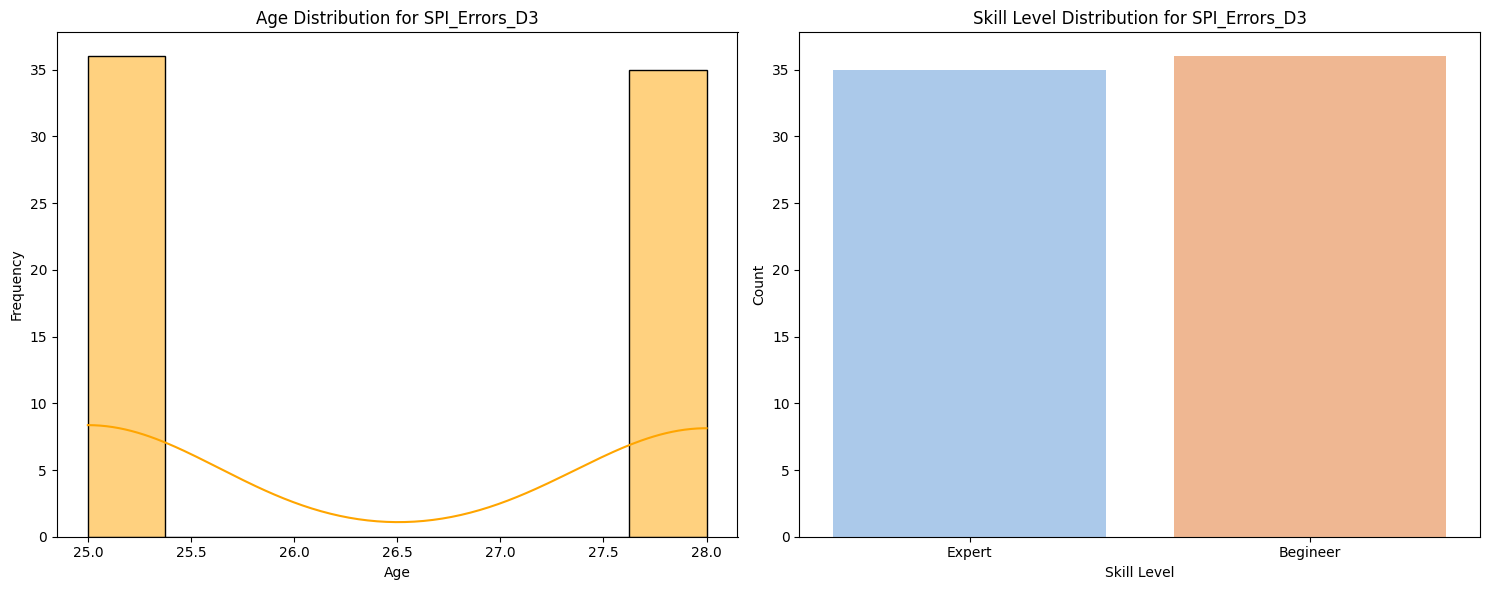

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/3182167064.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


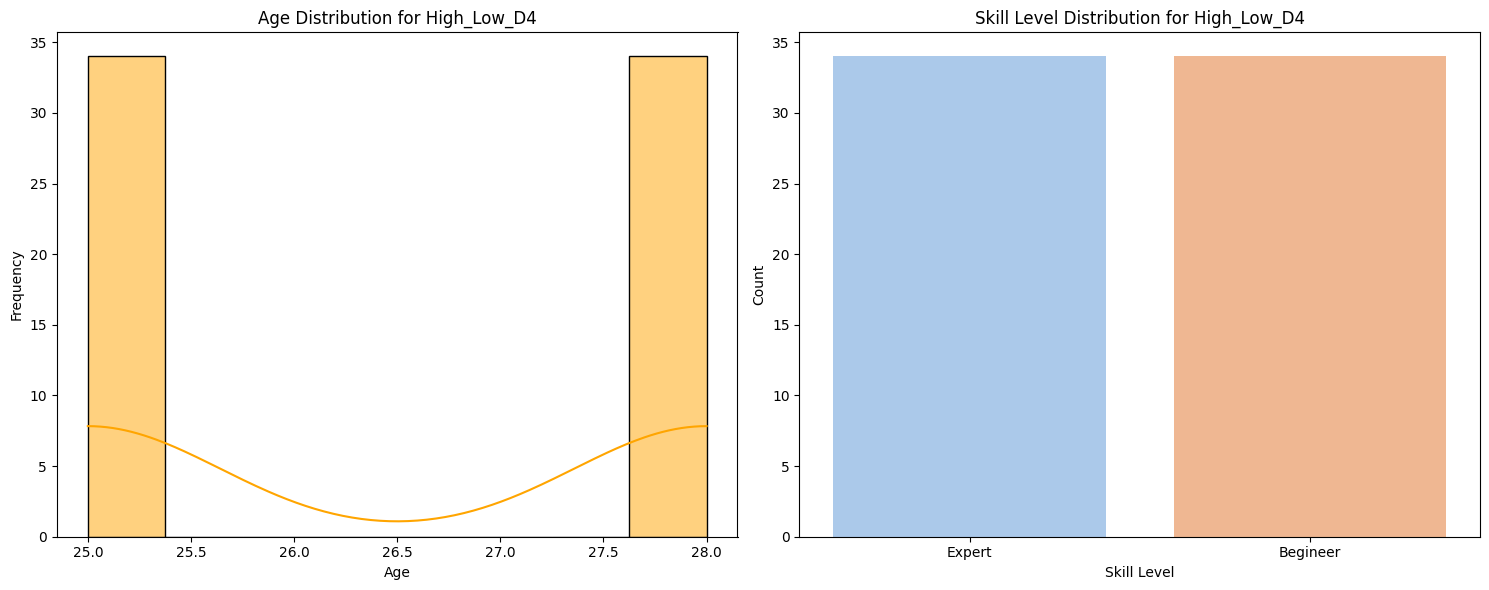

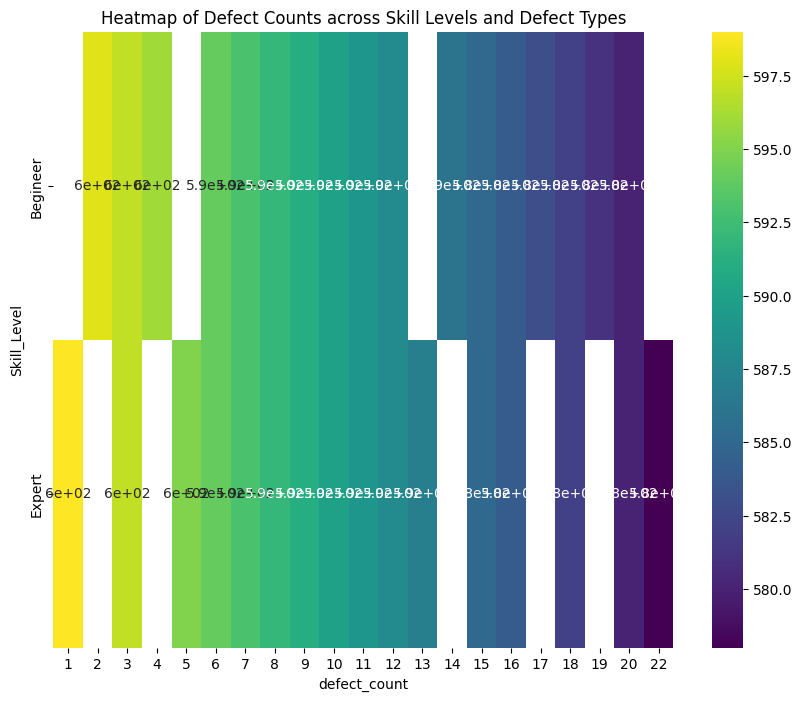

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Read the data
demographic_data = pd.read_csv('demographic_data_dataset.csv')
defect_data = pd.read_csv('updated_worker_defect_details.csv')

# Combine datasets on Worker_ID
combined_data = pd.merge(defect_data, demographic_data, on='Worker_ID')

# Drop unnecessary columns
fields_to_drop = ['Name', 'Joining_Date']
combined_data.drop(columns=fields_to_drop, inplace=True)

# Debugging: Print combined data columns
print("Combined Data Columns:", combined_data.columns)
print()

# Define categorical features for one-hot encoding
categorical_features = ['Gender', 'Skill_Level']
numerical_features = ['Age', 'Production_Volume']

# Ensure that all columns are present
missing_columns = [col for col in categorical_features + numerical_features if col not in combined_data.columns]
if missing_columns:
    raise ValueError(f"The following columns are missing in the combined dataset: {missing_columns}")

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Separate features and target variables
X = combined_data.drop(columns=['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4', 'defect_count', 'count', 'Worker_ID', 'Date', 'Shift'])
y = combined_data[['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']]

# Debugging: Print X and y columns
print("Feature Columns (X):", X.columns)
print("Target Columns (y):", y.columns)
print()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define multiple models
models = {
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'GradientBoosting': MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'SupportVector': MultiOutputRegressor(SVR())
}

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -cv_scores.mean()  # Negate because cross_val_score uses negative MSE
    print(f"{model_name}: Mean CV MSE = {-cv_scores.mean()}")
print()

# Select the best model
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

print(f"Best model: {best_model_name} with Mean CV MSE = {results[best_model_name]}")
print()

# Train the best model on the full training data
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model and print MSE for each defect type
mse_values = mean_squared_error(y_test, y_pred, multioutput='raw_values')
defect_types = ['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']

for defect_type, mse in zip(defect_types, mse_values):
    print(f"Mean Squared Error for {defect_type}: {mse}")

# Overall MSE
overall_mse = mean_squared_error(y_test, y_pred)
print(f"Overall Mean Squared Error: {overall_mse}")

# Function to get feature names after preprocessing
def get_feature_names(preprocessor, numerical_features, categorical_features):
    feature_names = numerical_features
    ohe_categories = preprocessor.transformers_[0][1].categories_
    cat_names = []
    for i, cat in enumerate(categorical_features):
        cat_names.extend([f"{cat}_{ohe_categories[i][j]}" for j in range(len(ohe_categories[i]))])
    feature_names.extend(cat_names)
    return feature_names

# Get the feature names
feature_names = get_feature_names(preprocessor, numerical_features, categorical_features)

# Debugging print statements to verify shapes
print(f"Feature names: {len(feature_names)}")
print(f"X_train shape: {X_train.shape}")
print()

# Plot feature importances for each defect type (for tree-based models)
if hasattr(best_model, 'estimators_'):
    for i, defect_type in enumerate(defect_types):
        importances = pipeline.named_steps['regressor'].estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Debugging print statements to verify shapes
        print(f"Importances shape: {importances.shape}")
        print(f"indices shape: {indices.shape}")

        # Plot the feature importances for each defect type
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importances for {defect_type}")
        plt.bar(range(len(importances)), importances[indices], align='center', color='orange')
        plt.xticks(range(len(importances)), [feature_names[j] for j in indices], rotation=90)
        plt.xlim([-1, len(importances)])
        plt.show()

# Demographic Analysis for Age and Skill Level
def analyze_demographics(data, demographic_feature):
    for defect_type in defect_types:
        subset = data[data[defect_type] > 0]  # Filter rows where the defect type count is greater than 0
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
        
        # Age Distribution
        sns.histplot(subset['Age'], ax=axes[0], kde=True, color='orange')
        axes[0].set_title(f'Age Distribution for {defect_type}')
        axes[0].set_xlabel('Age')
        axes[0].set_ylabel('Frequency')
        
        # Skill Level Distribution
        sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')
        axes[1].set_title(f'Skill Level Distribution for {defect_type}')
        axes[1].set_xlabel('Skill Level')
        axes[1].set_ylabel('Count')
        
        plt.tight_layout()
        plt.show()

# Analyze the effect of Age and Skill Level on each defect type
analyze_demographics(combined_data, 'Age')
analyze_demographics(combined_data, 'Skill_Level')

# Heatmap of defect counts across skill levels and defect types
pivot_table = combined_data.pivot_table(index='Skill_Level', columns='defect_count', values='count', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Heatmap of Defect Counts across Skill Levels and Defect Types')
plt.show()


Combined Data Columns: Index(['Worker_ID', 'Date', 'Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3',
       'High_Low_D4', 'Production_Volume', 'Shift', 'defect_count', 'count',
       'Age', 'Gender', 'Skill_Level', 'Unnamed: 6'],
      dtype='object')

Feature Columns (X): Index(['Production_Volume', 'Age', 'Gender', 'Skill_Level', 'Unnamed: 6'], dtype='object')
Target Columns (y): Index(['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4'], dtype='object')

RandomForest: Mean CV MSE = 4.954623847493965
GradientBoosting: Mean CV MSE = 4.952273866231022
LinearRegression: Mean CV MSE = 4.952278097537348
SupportVector: Mean CV MSE = 5.378071429036065

Best model: GradientBoosting with Mean CV MSE = 4.952273866231022

Mean Squared Error for Run_Off_D1: 5.292562991796079
Mean Squared Error for Open_Seam_D2: 3.0785639742247186
Mean Squared Error for SPI_Errors_D3: 4.98624927690371
Mean Squared Error for High_Low_D4: 5.542851679266722
Overall Mean Squared Error: 4.725056980547807
Feat

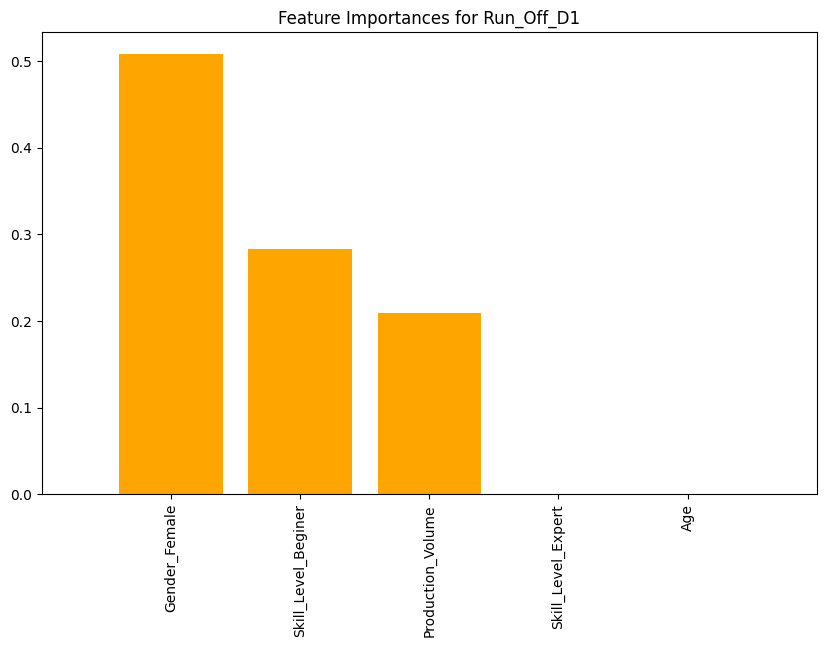

Importances shape: (5,)
indices shape: (5,)


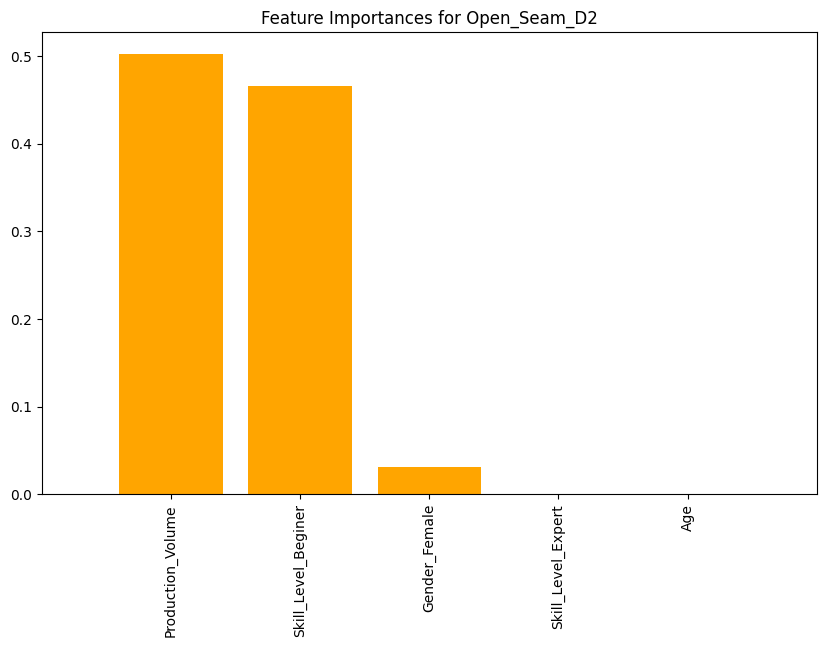

Importances shape: (5,)
indices shape: (5,)


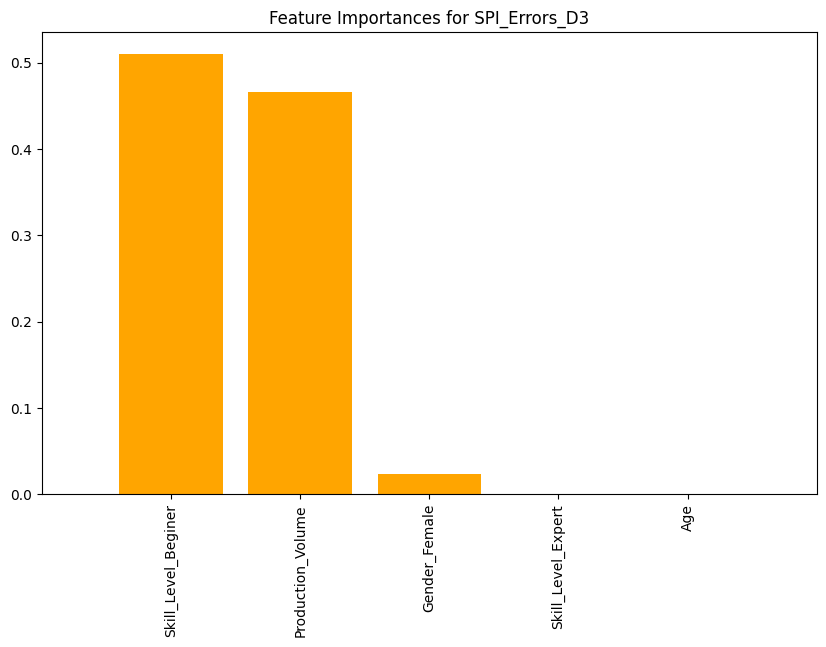

Importances shape: (5,)
indices shape: (5,)


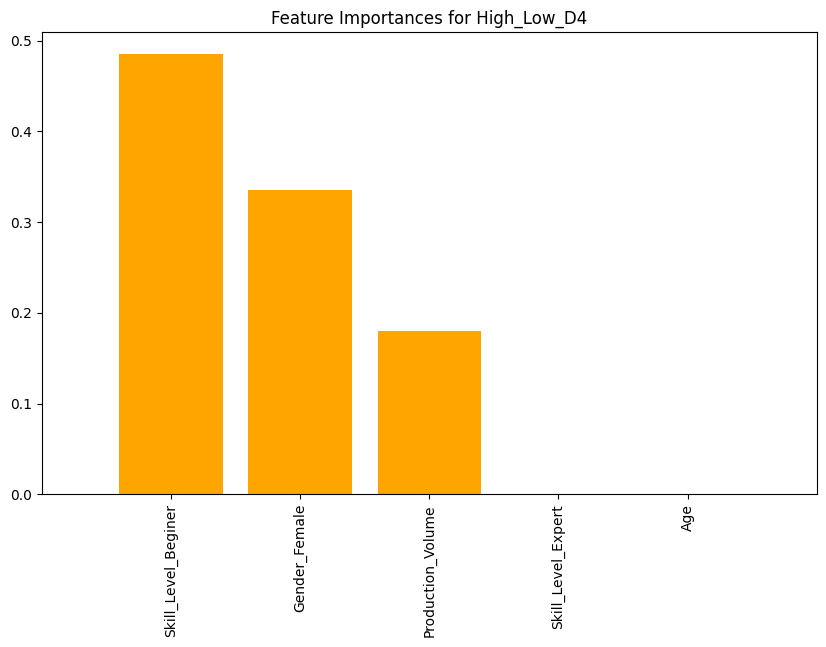

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


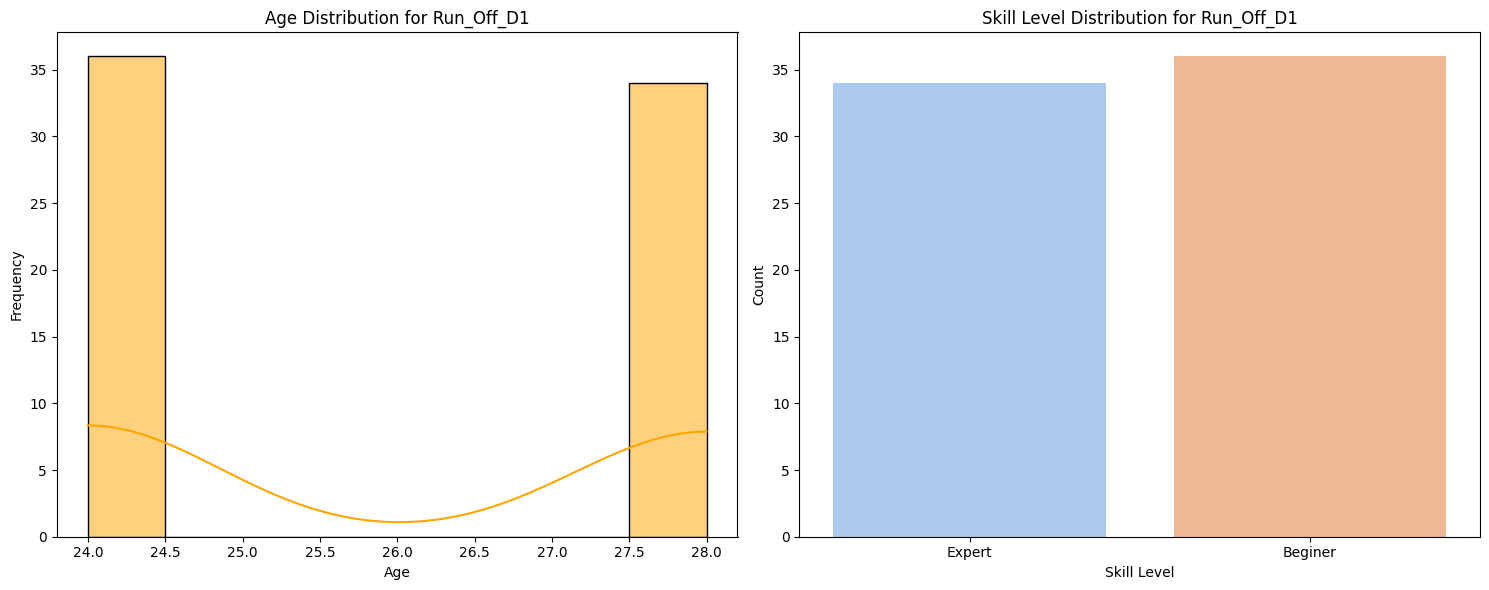

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


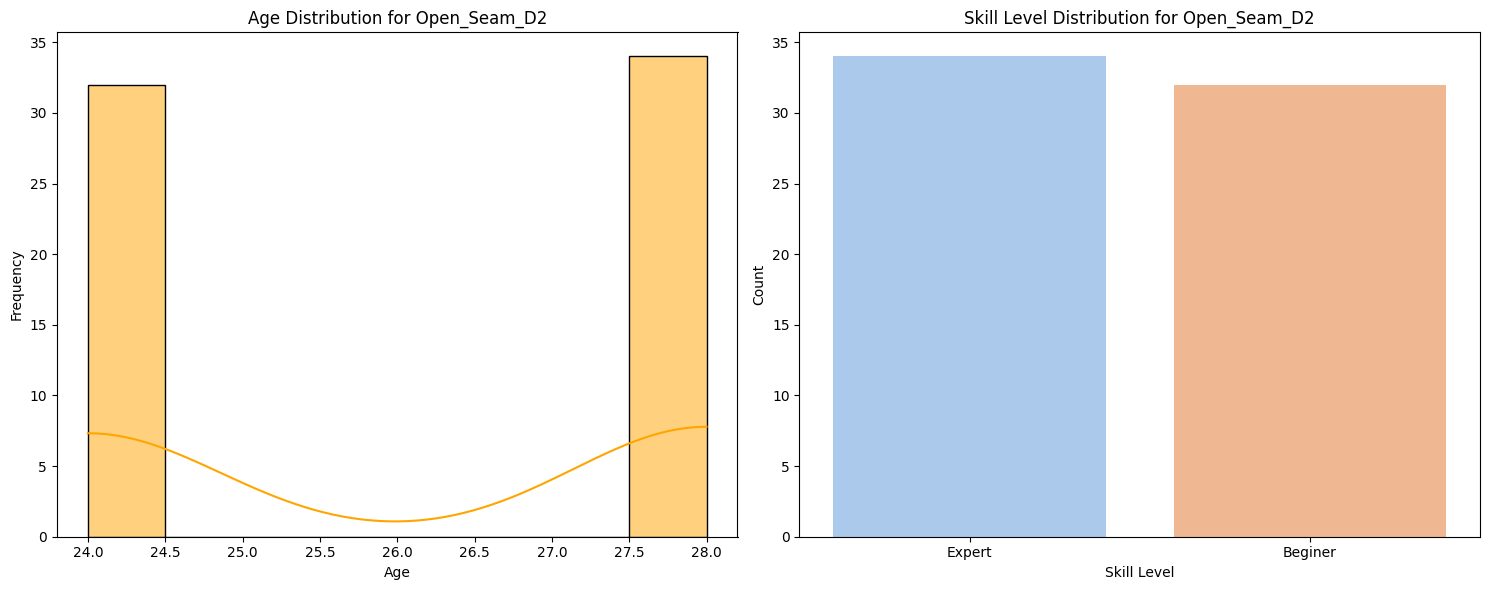

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


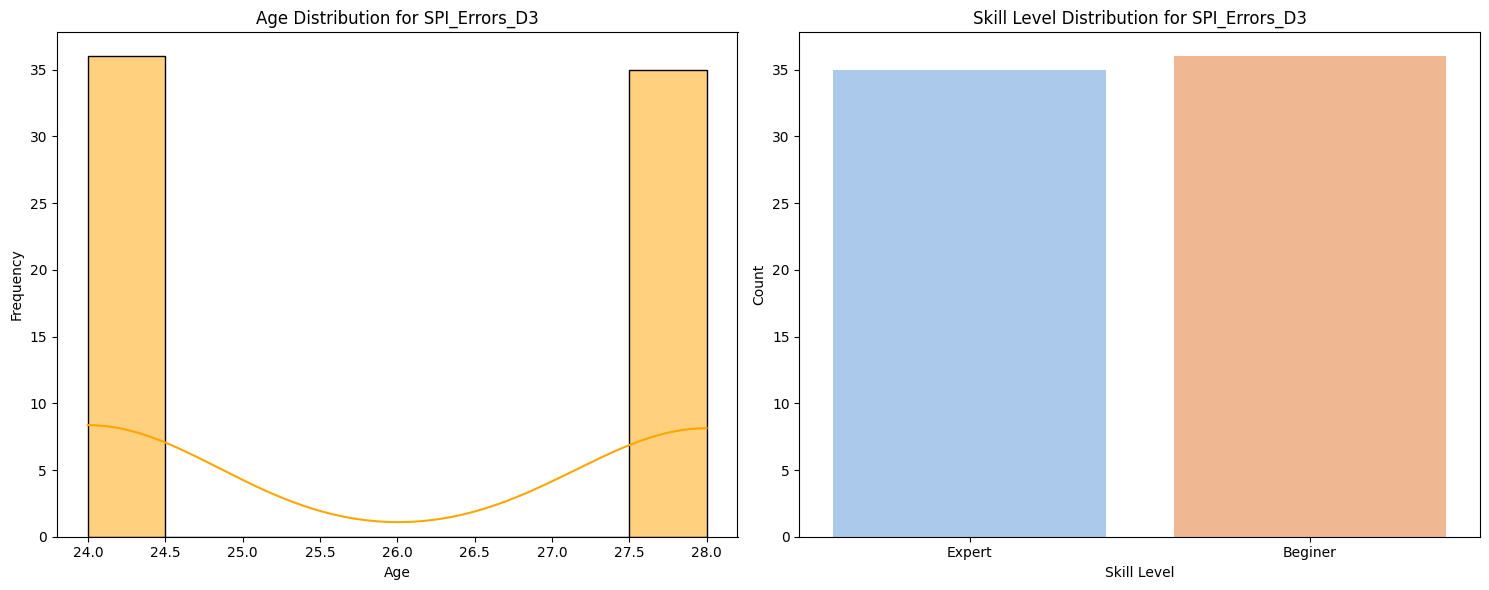

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


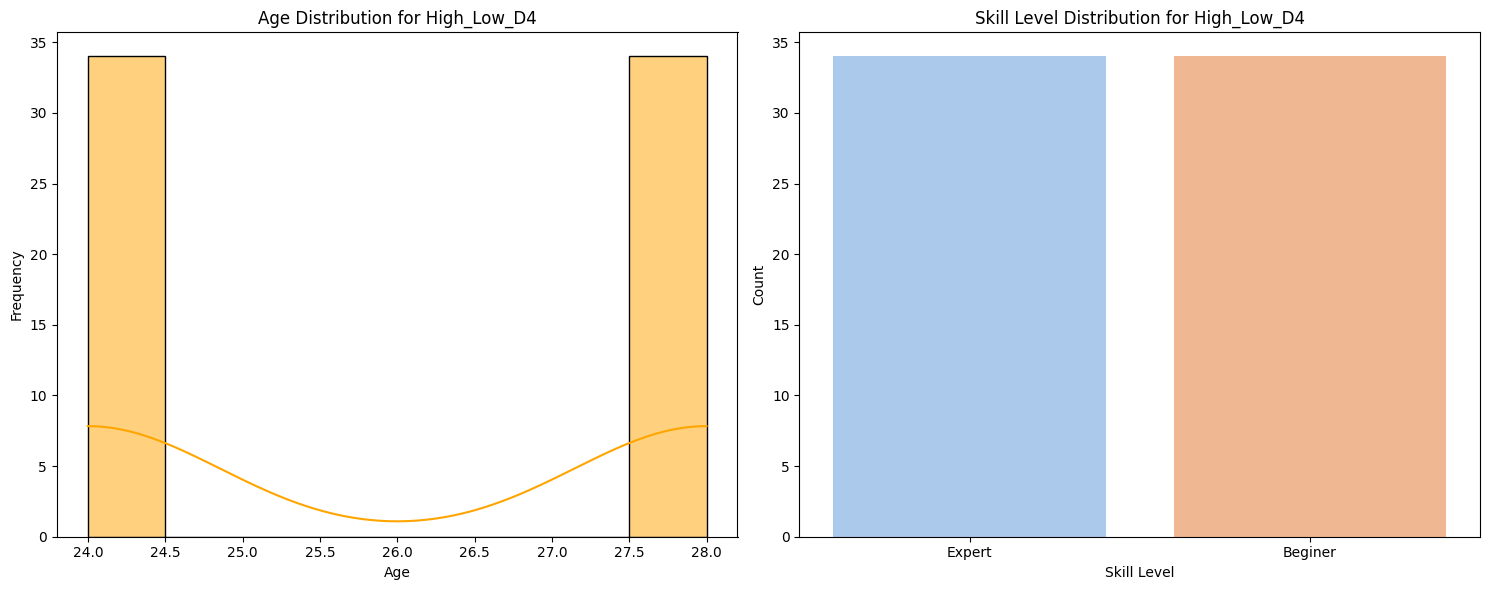

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


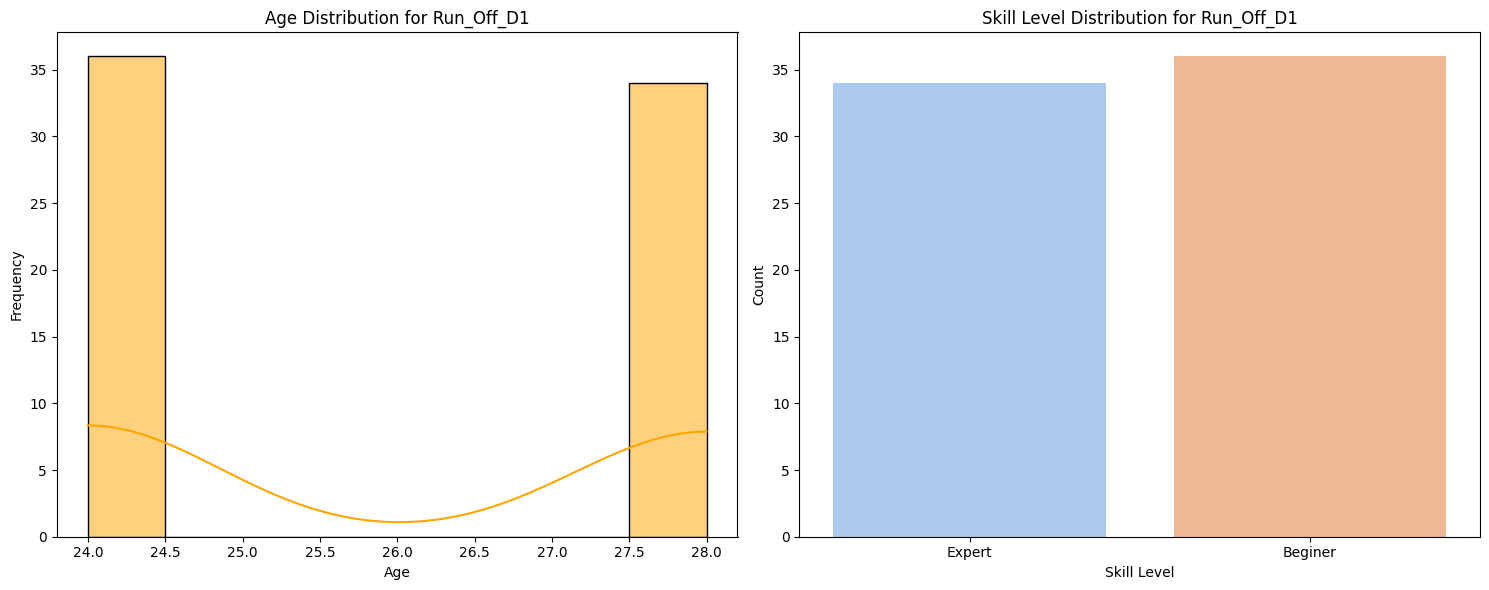

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


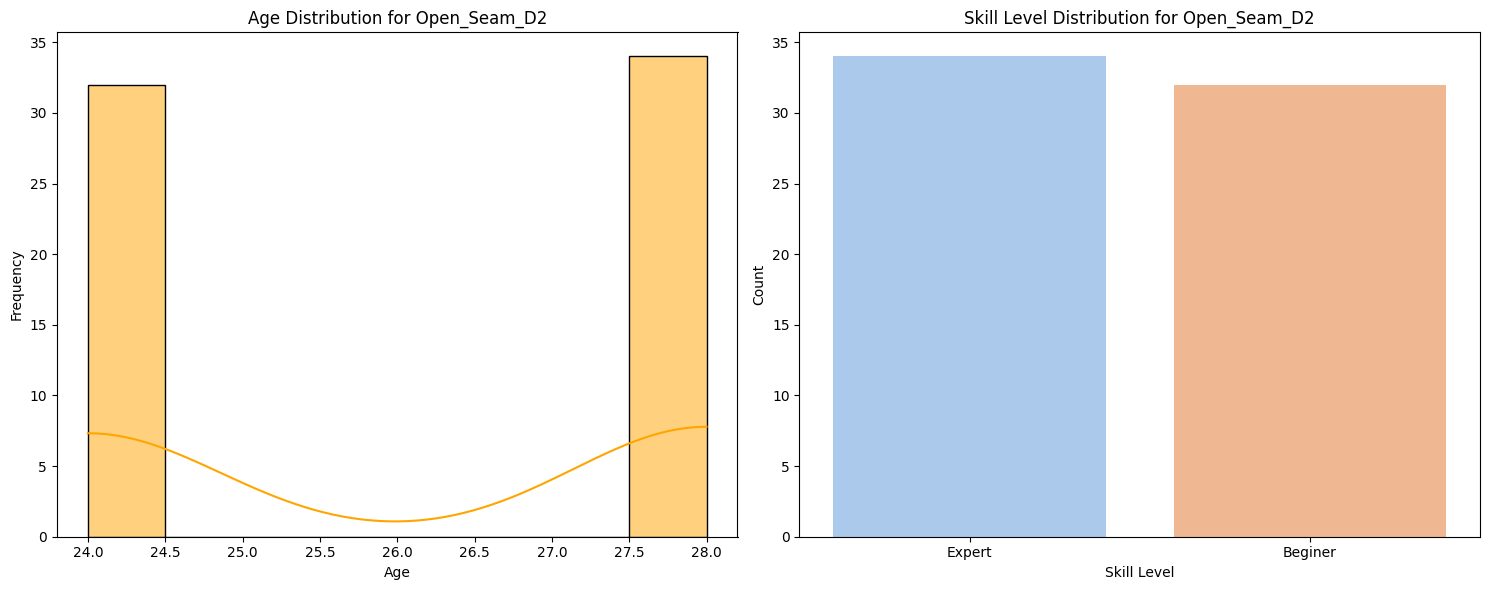

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


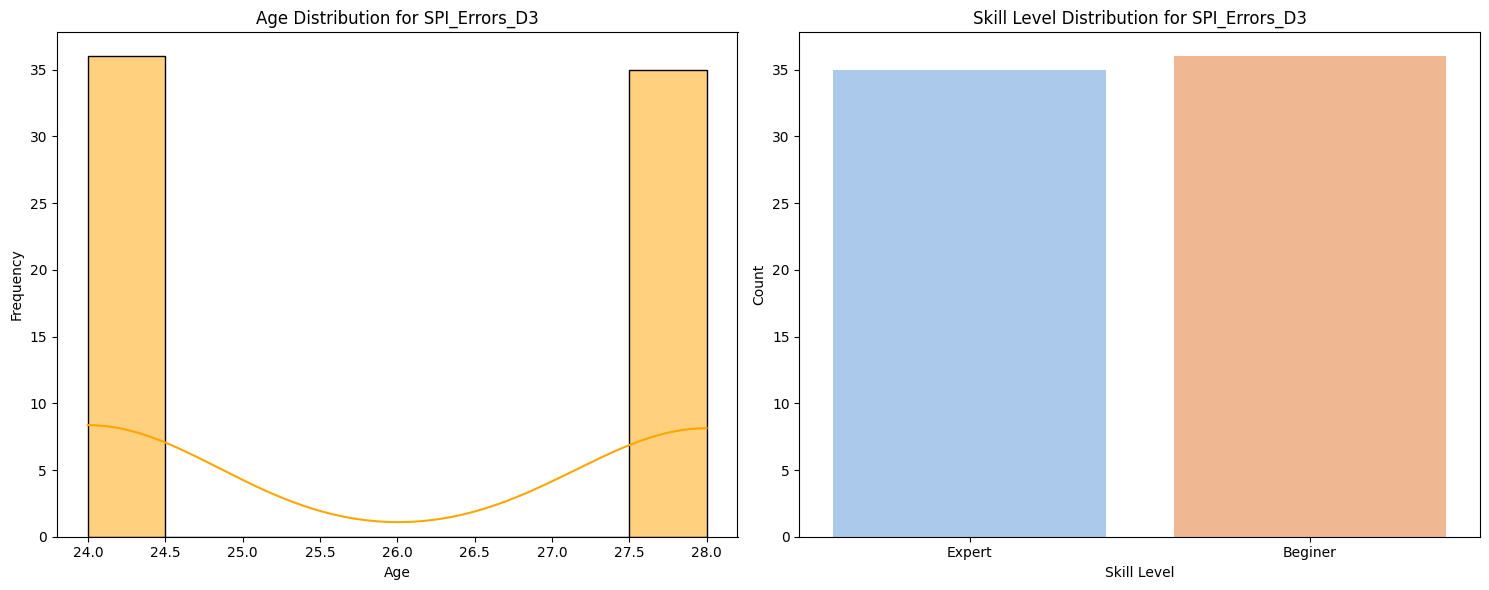

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')


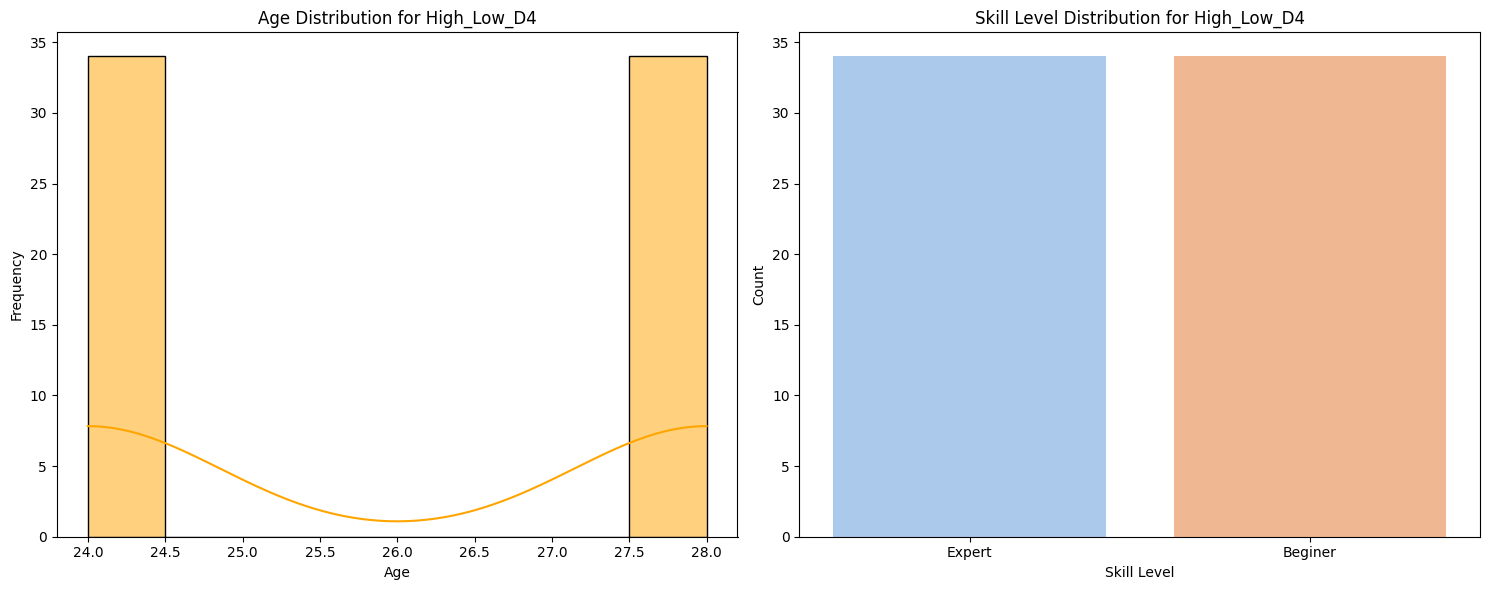

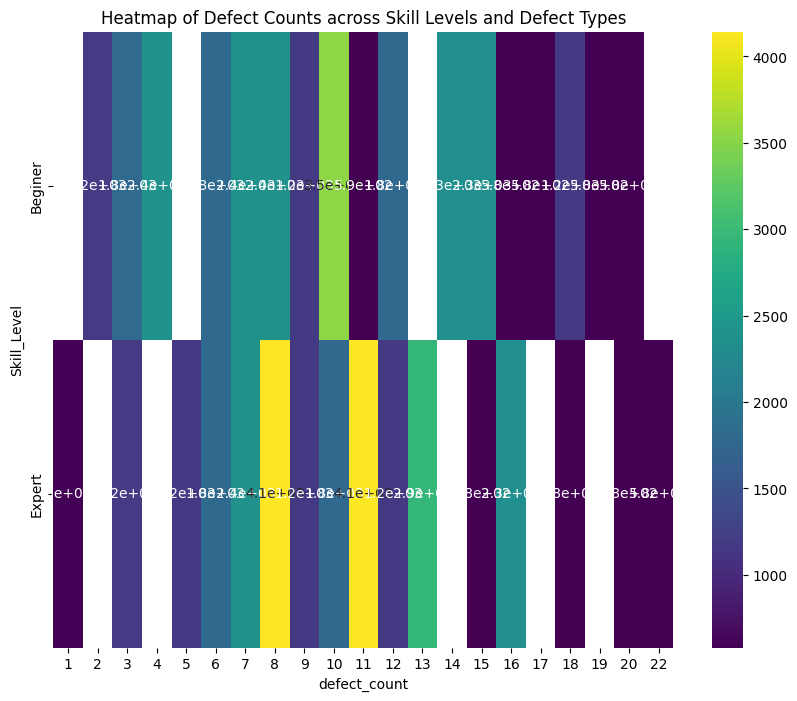

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:179: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=combined_data, x='Skill_Level', y='count', ci=None, palette='viridis')
/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=combined_data, x='Skill_Level', y='count', ci=None, palette='viridis')


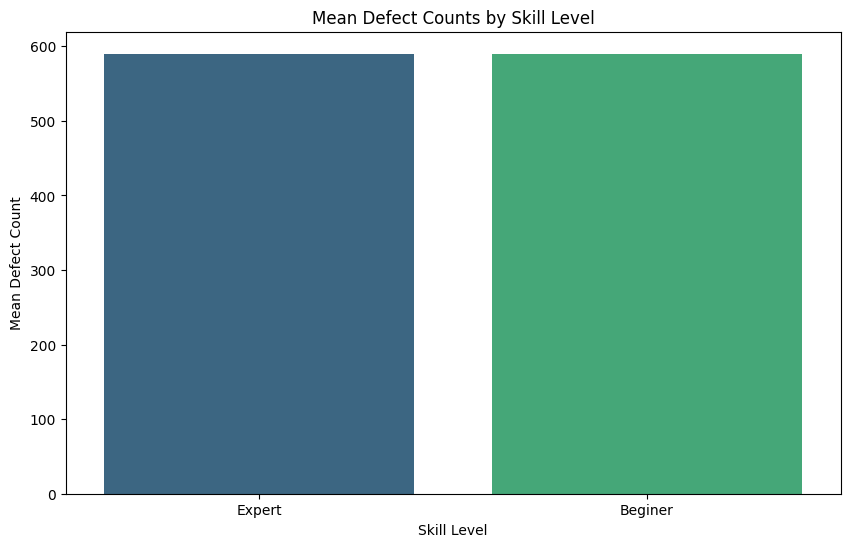

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:187: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=combined_data, x='Gender', y='count', ci=None, palette='viridis')
/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:187: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=combined_data, x='Gender', y='count', ci=None, palette='viridis')


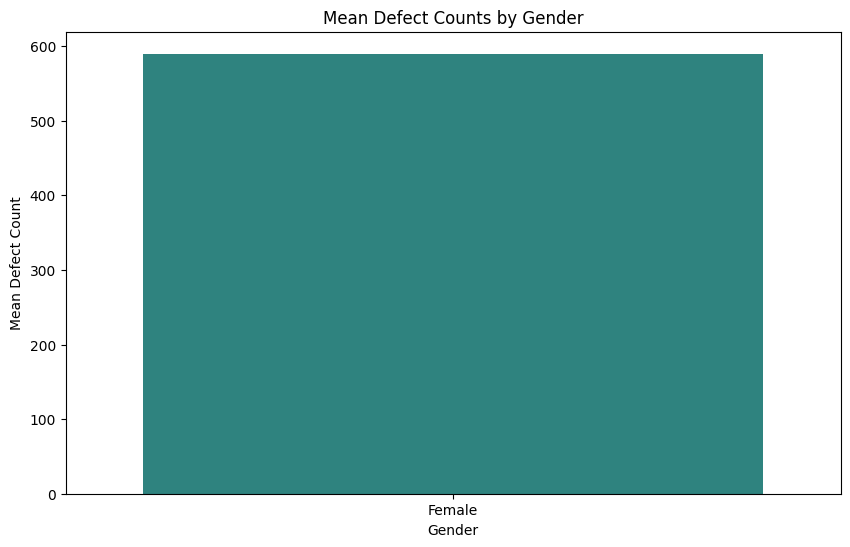

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:195: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='defect_count', y='Age', palette='viridis')


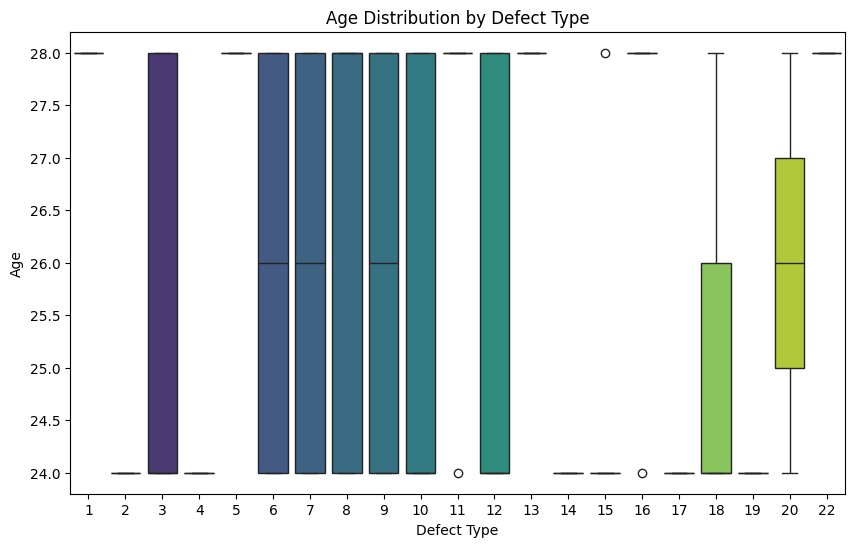

/var/folders/68/8_7nlx1973v1qqcz0zq5wt8m0000gn/T/ipykernel_5100/1090484676.py:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='defect_count', y='Production_Volume', palette='viridis')


<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

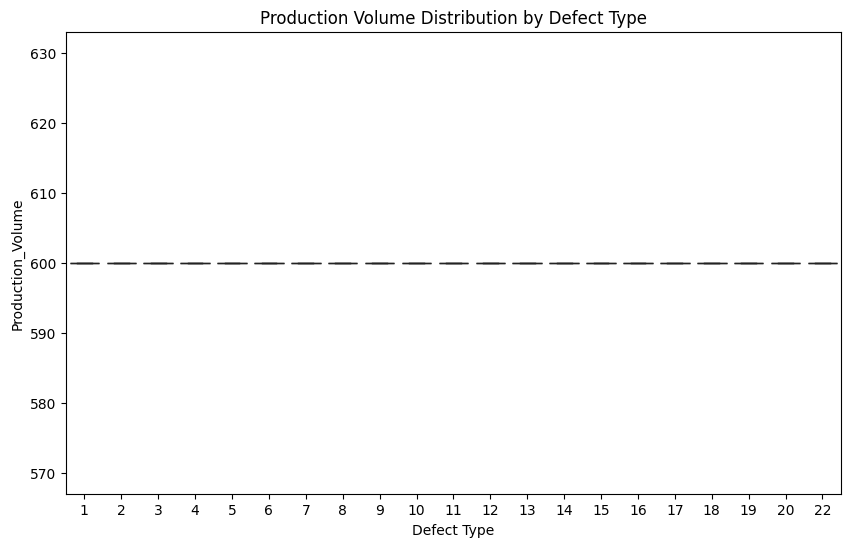

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Read the data
demographic_data = pd.read_csv('demographic_data_dataset.csv')  # Update path
defect_data = pd.read_csv('updated_worker_defect_details.csv')  # Update path

# Combine datasets on Worker_ID
combined_data = pd.merge(defect_data, demographic_data, on='Worker_ID')

# Drop unnecessary columns
fields_to_drop = ['Name', 'Joining_Date']
combined_data.drop(columns=fields_to_drop, inplace=True)

# Debugging: Print combined data columns
print("Combined Data Columns:", combined_data.columns)
print()

# Define categorical features for one-hot encoding
categorical_features = ['Gender', 'Skill_Level']
numerical_features = ['Age', 'Production_Volume']

# Ensure that all columns are present
missing_columns = [col for col in categorical_features + numerical_features if col not in combined_data.columns]
if missing_columns:
    raise ValueError(f"The following columns are missing in the combined dataset: {missing_columns}")

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Separate features and target variables
X = combined_data.drop(columns=['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4', 'defect_count', 'count', 'Worker_ID', 'Date', 'Shift'])
y = combined_data[['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']]

# Debugging: Print X and y columns
print("Feature Columns (X):", X.columns)
print("Target Columns (y):", y.columns)
print()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define multiple models
models = {
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'GradientBoosting': MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'SupportVector': MultiOutputRegressor(SVR())
}

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -cv_scores.mean()  # Negate because cross_val_score uses negative MSE
    print(f"{model_name}: Mean CV MSE = {-cv_scores.mean()}")
print()

# Select the best model
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

print(f"Best model: {best_model_name} with Mean CV MSE = {results[best_model_name]}")
print()

# Train the best model on the full training data
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model and print MSE for each defect type
mse_values = mean_squared_error(y_test, y_pred, multioutput='raw_values')
defect_types = ['Run_Off_D1', 'Open_Seam_D2', 'SPI_Errors_D3', 'High_Low_D4']

for defect_type, mse in zip(defect_types, mse_values):
    print(f"Mean Squared Error for {defect_type}: {mse}")

# Overall MSE
overall_mse = mean_squared_error(y_test, y_pred)
print(f"Overall Mean Squared Error: {overall_mse}")

# Function to get feature names after preprocessing
def get_feature_names(preprocessor, numerical_features, categorical_features):
    feature_names = numerical_features
    ohe_categories = preprocessor.transformers_[0][1].categories_
    cat_names = []
    for i, cat in enumerate(categorical_features):
        cat_names.extend([f"{cat}_{ohe_categories[i][j]}" for j in range(len(ohe_categories[i]))])
    feature_names.extend(cat_names)
    return feature_names

# Get the feature names
feature_names = get_feature_names(preprocessor, numerical_features, categorical_features)

# Debugging print statements to verify shapes
print(f"Feature names: {len(feature_names)}")
print(f"X_train shape: {X_train.shape}")
print()

# Plot feature importances for each defect type (for tree-based models)
if hasattr(best_model, 'estimators_'):
    for i, defect_type in enumerate(defect_types):
        importances = pipeline.named_steps['regressor'].estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Debugging print statements to verify shapes
        print(f"Importances shape: {importances.shape}")
        print(f"indices shape: {indices.shape}")

        # Plot the feature importances for each defect type
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importances for {defect_type}")
        plt.bar(range(len(importances)), importances[indices], align='center', color='orange')
        plt.xticks(range(len(importances)), [feature_names[j] for j in indices], rotation=90)
        plt.xlim([-1, len(importances)])
        plt.show()

# Demographic Analysis for Age and Skill Level
def analyze_demographics(data, demographic_feature):
    for defect_type in defect_types:
        subset = data[data[defect_type] > 0]  # Filter rows where the defect type count is greater than 0
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
        
        # Age Distribution
        sns.histplot(subset['Age'], ax=axes[0], kde=True, color='orange')
        axes[0].set_title(f'Age Distribution for {defect_type}')
        axes[0].set_xlabel('Age')
        axes[0].set_ylabel('Frequency')
        
        # Skill Level Distribution
        sns.countplot(x=subset['Skill_Level'], ax=axes[1], palette='pastel')
        axes[1].set_title(f'Skill Level Distribution for {defect_type}')
        axes[1].set_xlabel('Skill Level')
        axes[1].set_ylabel('Count')
        
        plt.tight_layout()
        plt.show()

# Analyze the effect of Age and Skill Level on each defect type
analyze_demographics(combined_data, 'Age')
analyze_demographics(combined_data, 'Skill_Level')

# Heatmap of defect counts across skill levels and defect types
pivot_table = combined_data.pivot_table(index='Skill_Level', columns='defect_count', values='count', aggfunc='sum')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Heatmap of Defect Counts across Skill Levels and Defect Types')
plt.show()

# Bar plot for mean defect counts by Skill Level
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_data, x='Skill_Level', y='count', ci=None, palette='viridis')
plt.title('Mean Defect Counts by Skill Level')
plt.xlabel('Skill Level')
plt.ylabel('Mean Defect Count')
plt.show()

# Bar plot for mean defect counts by Gender
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_data, x='Gender', y='count', ci=None, palette='viridis')
plt.title('Mean Defect Counts by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Defect Count')
plt.show()

# Box plot for Age distribution by defect type
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='defect_count', y='Age', palette='viridis')
plt.title('Age Distribution by Defect Type')
plt.xlabel('Defect Type')
plt.ylabel('Age')
plt.show()

# Box plot for Production Volume distribution by defect type
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='defect_count', y='Production_Volume', palette='viridis')
plt.title('Production Volume Distribution by Defect Type')
plt.xlabel('Defect Type')
plt.ylabel
